### Suleimenova Madina

### Exercise 1: Anomaly Detection

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from scipy.stats import zscore

# 1. Data Collection
# Load the dataset
df = pd.read_csv('C:\\Users\\sulej\\OneDrive\\Рабочий стол\\7 semester\\Data Mining\\creditcard.csv')  # Replace 'data.csv' with your dataset file path
print(df.head())  # Initial EDA

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [2]:
# 2. Data Preprocessing
# Handling missing values
df.fillna(df.median(), inplace=True)

# Handling outliers (using Z-score)
df = df[(np.abs(zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)]

# Normalization/Standardization (if necessary)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df)


In [8]:
# Reduce the dataset size for performance optimization
df_sample = df.sample(frac=0.15, random_state=42)  # Use 15% of the data

In [9]:
# 3. Anomaly Detection Techniques
# Statistical Method - Z-Score
df_sample['anomaly_zscore'] = (np.abs(zscore(df_sample.select_dtypes(include=np.number))) > 3).any(axis=1).astype(int)

# Machine Learning Method - Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df_sample['anomaly_if'] = iso_forest.fit_predict(df_sample.drop('anomaly_zscore', axis=1))
df_sample['anomaly_if'] = df_sample['anomaly_if'].apply(lambda x: 1 if x == -1 else 0)

# One-Class SVM
svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
df_sample['anomaly_ocsvm'] = svm.fit_predict(df_sample.drop(['anomaly_zscore', 'anomaly_if'], axis=1))
df_sample['anomaly_ocsvm'] = df_sample['anomaly_ocsvm'].apply(lambda x: 1 if x == -1 else 0)

# Print the first few rows to verify
print(df_sample.head())

            Time        V1        V2        V3        V4        V5        V6  \
107991 -0.509805 -1.117152  0.245518  1.004418 -0.877457  0.388048  1.196387   
87661  -0.698447  0.661739 -0.273469  0.850671  0.164421 -1.110793 -0.322429   
256911  1.333473 -1.104693 -0.100484 -0.623590 -1.538038  3.837665  2.823939   
112193 -0.470809 -1.034482  0.716485  0.895721  0.072415 -0.020267 -0.741446   
66107  -0.907548  0.520284 -0.331205  0.657761  0.548759 -0.997411 -0.476766   

              V7        V8        V9  ...       V24       V25       V26  \
107991 -0.648599  2.091580 -0.393149  ... -1.744523 -2.013084  1.563974   
87661  -0.861943 -0.149494  1.015078  ...  0.851038  0.293803  2.144293   
256911  0.372174  1.033232  0.119280  ...  1.246165 -0.230248  0.359909   
112193  1.686948 -0.598035 -0.596736  ...  0.688872  1.175529  0.892518   
66107  -0.455066 -0.279014  0.474868  ...  0.737000  0.258858  0.829544   

             V27       V28    Amount  Class  anomaly_zscore  anomaly

Isolation Forest - Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Confusion Matrix:
 [[9936    0]
 [   0 1177]]


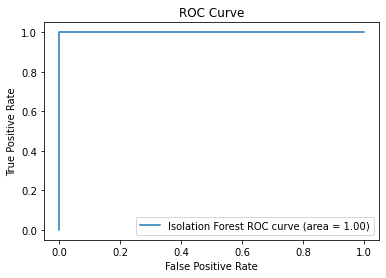

In [10]:
# 4. Model Evaluation
# Splitting data (use df_sample for performance optimization)
X_train, X_test, y_train, y_test = train_test_split(
    df_sample.drop(['anomaly_zscore', 'anomaly_if', 'anomaly_ocsvm'], axis=1),
    df_sample['anomaly_if'],
    test_size=0.3,
    random_state=42
)

# Evaluate Isolation Forest
precision = precision_score(y_test, df_sample.loc[y_test.index, 'anomaly_if'])
recall = recall_score(y_test, df_sample.loc[y_test.index, 'anomaly_if'])
f1 = f1_score(y_test, df_sample.loc[y_test.index, 'anomaly_if'])
print(f"Isolation Forest - Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Confusion Matrix & ROC
cm = confusion_matrix(y_test, df_sample.loc[y_test.index, 'anomaly_if'])
print("Confusion Matrix:\n", cm)
fpr, tpr, thresholds = roc_curve(y_test, df_sample.loc[y_test.index, 'anomaly_if'])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.plot(fpr, tpr, label=f'Isolation Forest ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

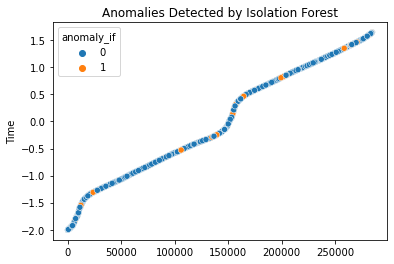

Number of detected anomalies by Isolation Forest: 3704


In [11]:
# 5. Visualization
sns.scatterplot(
    x=df_sample.index, 
    y=df_sample[df_sample.columns[0]], 
    hue='anomaly_if', 
    data=df_sample
)
plt.title("Anomalies Detected by Isolation Forest")
plt.show()

# 6. Reporting Findings
print(f"Number of detected anomalies by Isolation Forest: {df_sample['anomaly_if'].sum()}")

In [12]:
print(df_sample.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37041 entries, 107991 to 146704
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Time            37041 non-null  float64
 1   V1              37041 non-null  float64
 2   V2              37041 non-null  float64
 3   V3              37041 non-null  float64
 4   V4              37041 non-null  float64
 5   V5              37041 non-null  float64
 6   V6              37041 non-null  float64
 7   V7              37041 non-null  float64
 8   V8              37041 non-null  float64
 9   V9              37041 non-null  float64
 10  V10             37041 non-null  float64
 11  V11             37041 non-null  float64
 12  V12             37041 non-null  float64
 13  V13             37041 non-null  float64
 14  V14             37041 non-null  float64
 15  V15             37041 non-null  float64
 16  V16             37041 non-null  float64
 17  V17             37041 non